# Analyzing naturalistic stimuli

In traditional list-learning free recall experiments, remembering is often cast as a binary operation: either an item is recalled or it isn't. This allows for a straight forward matching between the presented and recalled stimuli. However, characterizing and evaluating memory in more realistic contexts (e.g., telling a story to a friend about a recent vacation) is much more nuanced. Real-world recall is continuous, rather than binary. Further, the specific words used to describe an experience may vary considerably across participants. To handle this new data regime, we extended classic methods developed for free-recall list-learning experiments to accomodate naturalistic stimuli. Specifically, we provide a more flexible 'matching function', which quantifies the similarity between stimuli and verbal responses in a continuous manner.

In the tutorial below, we will describe our new analysis approach and demonstrate how to perform the analyses using `quail`. To get started, let's load in the example data:

In [1]:
import quail
import numpy as np
import seaborn as sns
from scipy.spatial.distance import cdist

%matplotlib inline
egg = quail.load_example_data(dataset='naturalistic')

The example data used in this tutorial is based on an open dataset from Chen et al., 2017, in which 17 participants viewed and then verbally recounted an episode of the BBC series _Sherlock_. We fit a topic model to hand-annotated text descriptions of the episode and used the model to transform the video annotations and the recall transcriptions for each subject. We then used a Hidden Markov Model to segment the video and recall models into an (optimal) number of events. The result was a matrix of topic vectors representing the "events" in the video and list of matrices of topic vectors representing participant's recall "events". We created an `egg` from these vector representations of the stimulus and verbal recall,  where the topic vectors were passed to quail as a stimulus features. Let's take a closer look at the egg:

In [2]:
egg.info()

Number of subjects: 17
Number of lists per subject: 1
Number of words per list: 34
Date created: Wed Aug 15 12:38:13 2018
Meta data: {}


Here, the egg's `pres` field consists of 34 stimulus events (the number of video segments determined by our HMM). Each stimulus event is represented by a dictionary containing the label of the video segment (`item`) and a topic vector representing that event (`topics`).

In [3]:
# The label of each stimulus event...
egg.get_pres_items().head()

,,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
1,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
2,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
3,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
4,0,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33


In [4]:
# ...and their corresponding topic vectors
egg.get_pres_features().head()

,,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,"{'topics': [1.3095040225638681e-05, 1.30950402...","{'topics': [1.1307998068474283e-05, 1.13079980...","{'topics': [9.693039650300355e-06, 9.693039650...","{'topics': [9.913957255604304e-06, 9.913957255...","{'topics': [1.0626906175571998e-05, 1.06269061...","{'topics': [1.0663216195539594e-05, 1.06632161...","{'topics': [1.0532922580253435e-05, 1.05329225...","{'topics': [1.022682519393662e-05, 1.022682519...","{'topics': [9.815446687603108e-06, 9.815446687...","{'topics': [9.707331800972813e-06, 9.707331800...",...,"{'topics': [1.1240052636101565e-05, 1.12400526...","{'topics': [1.2320787734091317e-05, 1.23207877...","{'topics': [1.224700269751644e-05, 1.224700269...","{'topics': [1.1916331700340415e-05, 1.19163317...","{'topics': [1.1204077693770254e-05, 1.12040776...","{'topics': [1.1367721441462295e-05, 1.13677214...","{'topics': [1.0987763886778575e-05, 1.09877638...","{'topics': [1.0659164036611576e-05, 1.06591640...","{'topics': [1.8863247709037007e-05, 1.88632477...","{'topics': [0.0001067916639972405, 0.000106791..."
1,0,"{'topics': [1.3095040225638681e-05, 1.30950402...","{'topics': [1.1307998068474283e-05, 1.13079980...","{'topics': [9.693039650300355e-06, 9.693039650...","{'topics': [9.913957255604304e-06, 9.913957255...","{'topics': [1.0626906175571998e-05, 1.06269061...","{'topics': [1.0663216195539594e-05, 1.06632161...","{'topics': [1.0532922580253435e-05, 1.05329225...","{'topics': [1.022682519393662e-05, 1.022682519...","{'topics': [9.815446687603108e-06, 9.815446687...","{'topics': [9.707331800972813e-06, 9.707331800...",...,"{'topics': [1.1240052636101565e-05, 1.12400526...","{'topics': [1.2320787734091317e-05, 1.23207877...","{'topics': [1.224700269751644e-05, 1.224700269...","{'topics': [1.1916331700340415e-05, 1.19163317...","{'topics': [1.1204077693770254e-05, 1.12040776...","{'topics': [1.1367721441462295e-05, 1.13677214...","{'topics': [1.0987763886778575e-05, 1.09877638...","{'topics': [1.0659164036611576e-05, 1.06591640...","{'topics': [1.8863247709037007e-05, 1.88632477...","{'topics': [0.0001067916639972405, 0.000106791..."
2,0,"{'topics': [1.3095040225638681e-05, 1.30950402...","{'topics': [1.1307998068474283e-05, 1.13079980...","{'topics': [9.693039650300355e-06, 9.693039650...","{'topics': [9.913957255604304e-06, 9.913957255...","{'topics': [1.0626906175571998e-05, 1.06269061...","{'topics': [1.0663216195539594e-05, 1.06632161...","{'topics': [1.0532922580253435e-05, 1.05329225...","{'topics': [1.022682519393662e-05, 1.022682519...","{'topics': [9.815446687603108e-06, 9.815446687...","{'topics': [9.707331800972813e-06, 9.707331800...",...,"{'topics': [1.1240052636101565e-05, 1.12400526...","{'topics': [1.2320787734091317e-05, 1.23207877...","{'topics': [1.224700269751644e-05, 1.224700269...","{'topics': [1.1916331700340415e-05, 1.19163317...","{'topics': [1.1204077693770254e-05, 1.12040776...","{'topics': [1.1367721441462295e-05, 1.13677214...","{'topics': [1.0987763886778575e-05, 1.09877638...","{'topics': [1.0659164036611576e-05, 1.06591640...","{'topics': [1.8863247709037007e-05, 1.88632477...","{'topics': [0.0001067916639972405, 0.000106791..."
3,0,"{'topics': [1.3095040225638681e-05, 1.30950402...","{'topics': [1.1307998068474283e-05, 1.13079980...","{'topics': [9.693039650300355e-06, 9.693039650...","{'topics': [9.913957255604304e-06, 9.913957255...","{'topics': [1.0626906175571998e-05, 1.06269061...","{'topics': [1.0663216195539594e-05, 1.06632161...","{'topics': [1.0532922580253435e-05, 1.05329225...","{'topics': [1.022682519393662e-05, 1.022682519...","{'topics': [9.815446687603108e-06, 9.815446687...","{'topics': [9.707331800972813e-06, 9.707331800...",...,"{'topics': [1.1240052636101565e-05, 1.12400526...","{'topics': [1.2320787734091317e-05, 1.23207877...","{'topics': [1.224700269751644e-05, 1.224700269...","{'topics': [1.1916331700340415e-05, 1.19163317...","{'topics': [1.120407769377025

In [5]:
# a closer look at one of the dictionaries
egg.get_pres_features()[0][0][0]

{'temporal': 0,
 'topics': array([1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 6.98128585e-02,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05, 1.30950402e-05, 1.30950402e-05,
        1.30950402e-05, 1.30950402e-05

As you can see above, the dictionary contains a `features` key, which holds a 100D topic vector representing a stimulus event and also a `temporal` key, which describes the serial position of the stimulus.  The `rec` field contains the recall events for each subject, similarly represented by a label (`'item'`) and topic vectors it comprises (`'topics'`).

In [6]:
# The temporal position of each recall event...
egg.get_rec_items().head()

,,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,8,7,10,19,23,26,31,8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,8,13,10,8,13,17,21,23,23.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,2,4,8,17,17,21,26,29.0,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,5,2,5,10,15,26,26,31.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1,21,2,4,4,8,17,17,21.0,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# ...and their corresponding topic vectors
egg.get_rec_features().head()

,,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,"{'topics': [0.00019430992385381985, 0.00019430...","{'topics': [0.00017027929367231326, 0.00017027...","{'topics': [0.00017369078885231097, 0.00017369...","{'topics': [0.00019384831708918682, 0.00019384...","{'topics': [0.00021172689406944874, 0.00021172...","{'topics': [0.0001967417938833908, 0.000196741...","{'topics': [0.00018739098716436903, 0.00018739...","{'topics': [0.0007029745321813258, 0.000702974...",{},{},...,{},{},{},{},{},{},{},{},{},{}
1,0,"{'topics': [0.0001893882261801681, 0.000189388...","{'topics': [0.000147870701282558, 0.0001478707...","{'topics': [0.00019023353033654396, 0.00019023...","{'topics': [0.00018166938444643692, 0.00018166...","{'topics': [0.0001625481095703973, 0.000162548...","{'topics': [0.00017324045166665215, 0.00017324...","{'topics': [0.00020984959154624308, 0.00020984...","{'topics': [0.00021871502948704968, 0.00021871...","{'topics': [0.00023880652209349367, 0.00023880...","{'topics': [0.00020811361546785266, 0.00020811...",...,{},{},{},{},{},{},{},{},{},{}
2,0,"{'topics': [0.00018590937074552605, 0.00018590...","{'topics': [0.0002086223458447991, 0.000208622...","{'topics': [0.00014376082951536893, 0.00014376...","{'topics': [0.00017953275349176222, 0.00017953...","{'topics': [0.0001266373016964342, 0.000126637...","{'topics': [0.00012300799059941801, 0.00012300...","{'topics': [0.00012981062271781097, 0.00012981...","{'topics': [0.00013602953297943621, 0.00013602...","{'topics': [0.00014111281486418062, 0.00014111...","{'topics': [0.00012592147339385905, 0.00012592...",...,{},{},{},{},{},{},{},{},{},{}
3,0,"{'topics': [0.00018228403991448364, 0.00018228...","{'topics': [0.00018629081950116504, 0.00018629...","{'topics': [0.0001622345358076629, 0.000162234...","{'topics': [0.00023810735183527187, 0.00023810...","{'topics': [0.0001552297878347715, 0.000155229...","{'topics': [0.00016179442394432278, 0.00016179...","{'topics': [0.00016889623308560304, 0.00016889...","{'topics': [0.00019056297121315633, 0.00019056...","{'topics': [0.0005565476190479086, 0.000556547...",{},...,{},{},{},{},{},{},{},{},{},{}
4,0,"{'topics': [0.00025446487845416085, 0.00025446...","{'topics': [0.00027871701312132265, 0.00027871...","{'topics': [0.00023918073796144946, 0.00023918...","{'topics': [0.00017315740792590048, 0.00017315...","{'topics': [0.0001356024754279286, 0.000135602...","{'topics': [9.160956058842264e-05, 9.160956058...","{'topics': [9.360224876174755e-05, 9.360224876...","{'topics': [0.00013752072250850062, 0.00013752...","{'topics': [0.0001320162835250347, 0.000132016...","{'topics': [0.00014302384767721986, 0.00014302...",...,{},{},{},{},{},{},{},{},{},{}


# Defining a matching function

As summarized above, `quail` supports the analysis of naturalistic stimuli by providing a more flexible way to match presented stimuli and recall responses. The matching function can be set using the `match` keyword argument in `egg.analyze`. There are three options: `'exact'`, `'best'`, and `'smooth'`. If `match='exact'`, the recall item must be identical to the stimulus to constitute a recall. This is the traditional approach for free recall experiments (either a subject accurately recalled the stimulus item, or did not) but it is not particularly useful with naturalistic data. For the naturalistic options, quail computes a similarity matrix comparing every recall event to every stimulus event. If `match='best'`, the recall response that is most similar to a given presented stimulus is labeled as recalled.  If `match='smooth'`, a weighted-average over recall responses is computed for each presented stimulus, where the weights are derived from the similarity between the stimulus and the recall event.  To illustrate this further, let's step through the analysis. First, let's create a matrix representing the presented stimulus where each row is an 'event' and each column is a topic dimension:

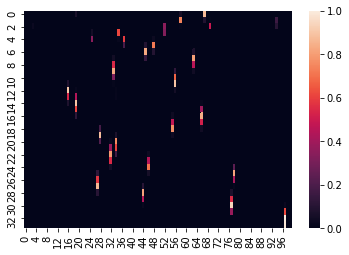

In [8]:
pres_mtx = np.array([x['topics'] for x in egg.get_pres_features('topics').iloc[0, :].values])
sns.heatmap(pres_mtx, vmin=0, vmax=1)

We'll also create a matrix representing the recalled events for a single subject:

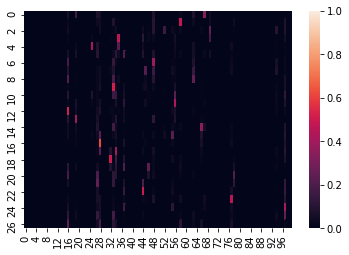

In [9]:
rec_mtx = np.array([x['topics'] for x in egg.get_rec_features('topics').iloc[12, :].values if len(x)])
sns.heatmap(rec_mtx, vmin=0, vmax=1)

To measure similarity between the `pres_mtx` and `rec_mtx` along this feature dimension, we can use the `cdist` function from `scipy`.  In this example, we will use correlational distance to measure similarity between each presented event and each recalled event:

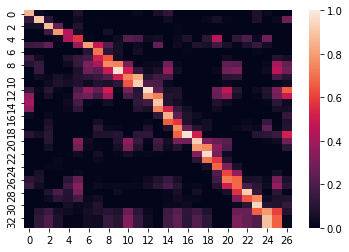

In [10]:
match_mtx = 1 - cdist(pres_mtx, rec_mtx, 'correlation')
sns.heatmap(match_mtx, vmin=0, vmax=1)

This matrix quantifies the match between each presented stimulus and each recalled stimulus. The light stripe along the diagonal suggests that this particular subject remembered most of the events in order, since the highest correlation values are roughly along the diagonal. 

## Matching with `'best'`

If `match='best'`, each recall event is mapped to the single stimulus event with the most similar feature vector:

In [11]:
np.argmax(match_mtx, 0)

array([ 0,  1,  2,  3,  3,  4,  5,  6,  8,  9, 10, 11, 12, 14, 16, 18, 19,
       20, 22, 24, 26, 27, 28, 30, 32, 32, 12])

Note that once the data is distilled into this form, many of the classic list-learning analyses (such as probability of first recall, serial position curve, and lag-conditional response probability curve) can be performed.  To do this using `quail`, simply set `match='best'`, choose a distance function (euclidean by default) and select the features that you would like to use (e.g. `features=['topics']`).

In [12]:
spc = egg.analyze(analysis='spc', match='best', distance='correlation', features=['topics'])
spc.get_data().head()

/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/quail/quail/analysis/recmat.py:103: RuntimeWarning: Mean of empty slice
  return np.nanmean(res, 1)


,,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Each stimulus event is assigned a binary value for each recall event – it either was matched or it was not. To plot it:

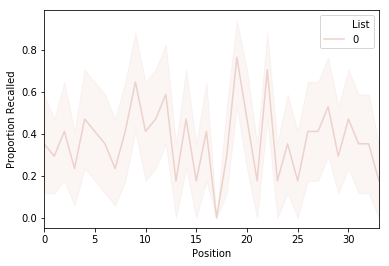

In [13]:
spc.plot()

## Matching with `'smooth'`

if `match='smooth'`, quail computes a weighted average across all stimulus events for each recall event, where the weights are derived from similarity between the stimulus and recall.

In [14]:
spc = egg.analyze(analysis='spc', match='smooth', distance='correlation', features=['topics'])
spc.data.head()

/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/quail/quail/analysis/recmat.py:103: RuntimeWarning: Mean of empty slice
  return np.nanmean(res, 1)


,,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
Subject,List,,,,,,,,,,,,,,,,,,,,,
0,0,0.007071,0.041853,0.009203,0.016614,0.033991,0.154249,0.017540,0.174531,0.292158,0.267374,...,0.104524,0.026187,0.097516,0.126987,0.103108,0.128083,0.107675,0.210723,0.185127,0.184987
1,0,0.001898,0.063795,-0.026356,0.029550,0.054097,0.018881,0.053997,0.070017,0.227520,0.263889,...,0.087016,0.008271,0.043307,0.075759,0.167584,0.182543,0.118617,0.164981,0.124798,0.124643
2,0,-0.027050,-0.020670,0.089779,0.038386,0.175139,0.026303,0.047882,0.079458,0.154467,0.155683,...,0.236841,0.113010,0.111786,0.086030,0.103987,0.142899,0.118404,0.111640,0.060170,0.060011
3,0,0.145299,0.046259,0.041661,0.058850,0.042346,0.165161,0.127778,0.050394,0.093302,0.110626,...,0.121584,0.113003,0.135094,0.105807,0.070675,0.117423,0.115852,0.141819,0.097215,0.097059
4,0,-0.022484,0.071523,0.022116,0.055897,0.094487,0.031469,0.026740,0.073415,0.085413,0.059973,...,0.004742,0.066363,0.116368,0.116870,0.115584,0.120936,0.084752,0.180413,0.163628,0.163519


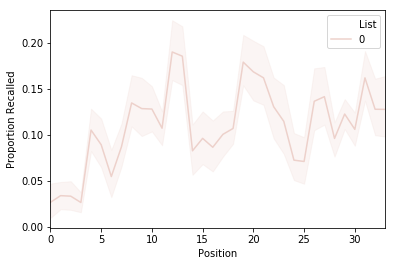

In [16]:
spc.plot()

# Changing the distance metric

The `distance` argument assigns the distance function quail will use to compute similarity between stimulus and recall events. We support any distance metric included in [scipy.spatial.distance.cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html):

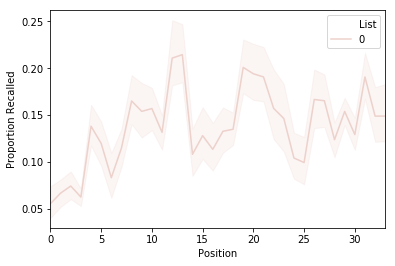

In [17]:
spc = egg.analyze(analysis='spc', match='smooth', distance='cosine', features=['topics'])
spc.plot()

# Selecting a subset of features

The `features` argument tells quail which features to consider when computing distance. This can be a single feature passed as a string, multiple features passed as a list, or all available features (`features=None`; default). 